In [15]:
import torchvision
from torch import Tensor, flatten
import numpy as np

from utils import train_vae_classifier
from vae.mnist_vae import  VaeAutoencoderClassifier
from plots import plot_training_result, plot_image_data
from dataset.mnist import prepare_mnist_dataset
from image_classifier.image_classifier import neural_network, train_model, test_model

In [16]:
training_data = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:60000] / 255.0
labels = training_data.targets[:60000]



In [17]:
vae = VaeAutoencoderClassifier(dim_encoding=2)

vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = train_vae_classifier(
    vae,
    training_data,
    batch_size=64,
    alpha=5000.0,
    epochs=10
)

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10


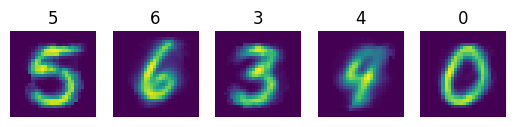

In [18]:
# plot generated data
image_tensor, label_tensor = vae.generate_data()
plot_image_data(image_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

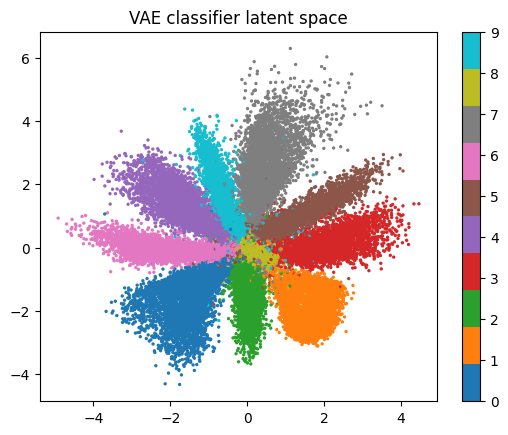

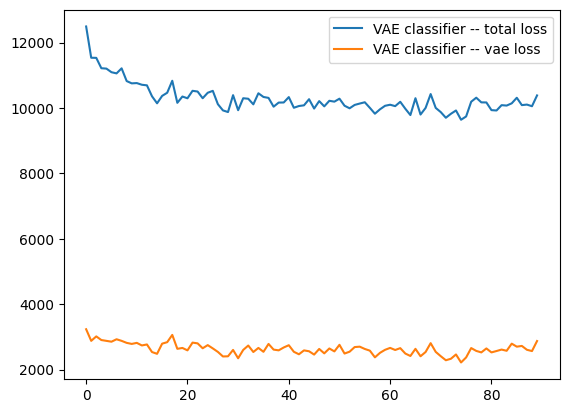

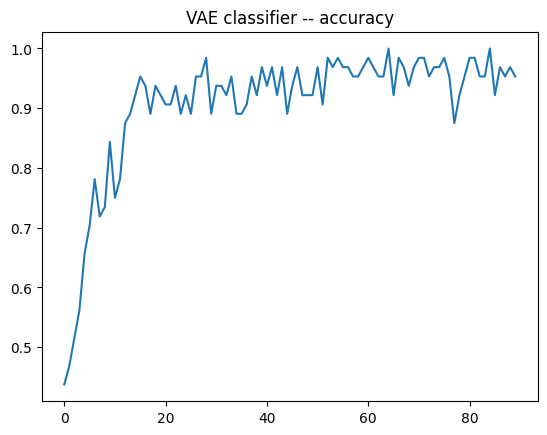

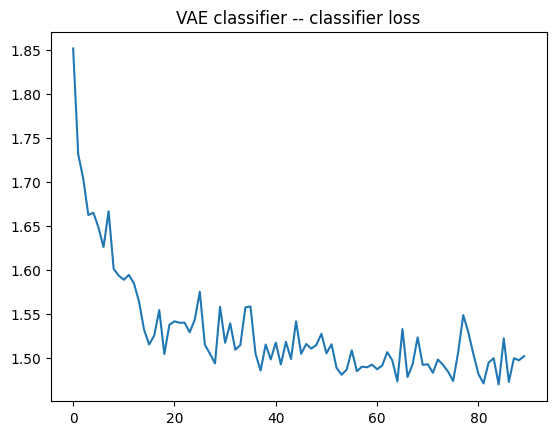

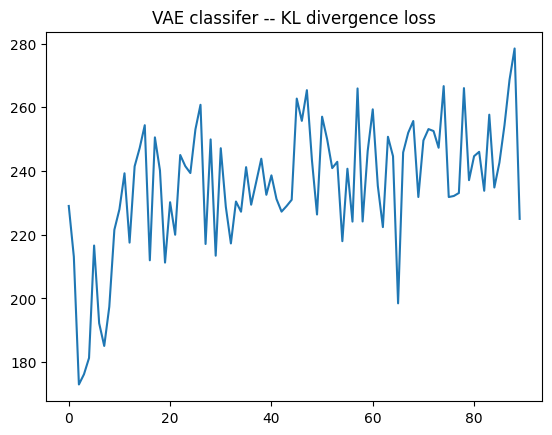

In [19]:
# plot results
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())

plot_training_result(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [20]:
# train classifier for performance evaluation
x_train, x_test, y_train, y_test = prepare_mnist_dataset()

nn_model = neural_network(num_classes=10, num_pixels=784)
train_model(nn_model, x_train, y_train, learning_rate=0.01, epochs=10)
test_model(nn_model, x_test, y_test)

Training images size:  56000
Training input size: 784
Training labels size: 56000
Testing images size:  14000
Testing input size: 784
Testing labels size: 14000
Normalized result (56000, 784) (14000, 784)
Output shape (56000, 10)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-05-02 12:25:30.197364: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 175616000 exceeds 10% of free system memory.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step - accuracy: 0.7289 - loss: 1.0280
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.9136 - loss: 0.3065
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.9295 - loss: 0.2507
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9422 - loss: 0.2067
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.9478 - loss: 0.1859
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.9536 - loss: 0.1614
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.9583 - loss: 0.1445
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.9637 - loss: 0.1314
Epoch 9/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.9669 - loss: 0.1177
Epoch 10/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.9700 - loss: 0.1076
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.9622 - loss: 0.1244
Error:  3.757143020629883 %


In [22]:
# generate data to be used in classifier
x = []
y = []

for i in range(100):
    image_tensor, label_tensor = vae.generate_data()
    image_tensor = flatten(image_tensor, 1)
    x.append(image_tensor.cpu().detach().numpy())
    y.append(label_tensor.cpu().detach().numpy())

gen_x = np.concatenate(x)
gen_y = np.concatenate(y)
assert gen_x.shape[1] == 784
assert gen_y.shape[1] == 10

print(gen_x.shape[0])
print(gen_y.shape[0])

assert gen_x.shape[0] == gen_y.shape[0]

digit_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for label in gen_y:
    digit_count[np.argmax(label)] += 1
print(digit_count)

3200
3200
[403, 900, 200, 286, 85, 314, 496, 300, 100, 116]


In [25]:
# test quality of images
test_model(nn_model, gen_x, gen_y)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.9761 - loss: 0.1951
Error:  2.5624990463256836 %
